In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

## KNNs

In [4]:
class EuclideanKNearestNeighbors:
    
    # Construtor
    def __init__(self, x, y, k):
        self.x = x
        self.y = y
        self.k = k
    
    # Getters
    def getX(self):
        return self.x
        
    def getY(self):
        return self.y
    
    def getK(self):
        return self.k
    
    # Setters
    def setX(self, x):
        self.x = x
        
    def setY(self, y):
        self.y = y
    
    def setK(self, k):
        self.k = k
        
    # Métodos
    def distance(self, x1, x2):
        return np.sqrt(((x1 - x2)**2).sum())
    
    def nearest(self, distances):
        near = distances[0]
        near_idx = 0
        for i, d in enumerate(distances):
            if d[0] < near[0]:
                near = d
                near_idx = i
        return near, near_idx
            
    def k_nearest(self, distances):
        k_near = np.zeros((self.k, self.x.shape[1]))
        for i in range(self.k):
            k_near[i], near_idx = self.nearest(distances)
            distances = np.delete(distances, near_idx, axis=0)
        return k_near
    
    def classify(self, new_x, append = False):
        
        distances = np.zeros(self.x.shape)
        
        for i, x in enumerate(self.x):
            distances[i, 0] = self.distance(x, new_x)
            distances[i, 1] = self.y[i]
            
        k_near = self.k_nearest(distances)
        clss = round(k_near[:, 1].mean())
        
        if append:
            self.x = np.vstack((self.x, new_x))
            self.y = np.vstack((self.y, clss))
        
        return clss

In [5]:
class MahalanobisKNearestNeighbors:
    
    # Construtor
    def __init__(self, x, y, k):
        self.x = x
        self.y = y
        self.k = k
        self.classes = int(np.amax(y) + 1) # Assume que a primeira classe é 0, a segunda é 1... etc
        self.n_per_class = np.zeros((self.classes, 1))
        self.cov = np.zeros((self.classes, x.shape[1], x.shape[1]))
        self.inv_cov = np.zeros(self.cov.shape)
        
        # Calcula n_per_class
        for clss in range(self.classes):
            self.n_per_class[clss] = len(y[y==clss])
        
        # Calcula a variância de cada feature para cada classe
        for clss in range(self.classes):
            self.cov[clss] = np.cov(x[(y == clss)[:, 0], :], rowvar=False)/self.n_per_class[clss]
            self.cov[clss] += np.identity(self.cov.shape[1]) * 1e-10
        
        self.inv_cov = np.linalg.inv(self.cov)
    
    # Getters
    def getX(self):
        return self.x
        
    def getY(self):
        return self.y
    
    def getK(self):
        return self.k
    
    def getCov(self):
        return self.cov
    
    # Setters
    def setXY(self, x, y):
        self.x = x
        self.y = y
        self.classes = np.amax(y) + 1 # Assume que a primeira classe é 0, a segunda é 1... etc
        self.n_per_class = np.zeros((self.classes, 1))
        self.cov = np.zeros((self.classes, x.shape[1], x.shape[1]))
        
        # Calcula n_per_class
        for clss in range(self.classes):
            self.n_per_class[clss] = len(y[y==clss])
        
        # Calcula a variância de cada feature para cada classe
        for clss in range(self.classes):
            self.cov[clss] = np.cov(x[y[:] == clss, :], rowvar=False)/self.n_per_class[clss]
            self.cov[clss] += np.identity(self.cov.shape[1]) * 1e-10
        
        self.inv_cov = np.linalg.inv(self.cov)
    
    def setK(self, k):
        self.k = k
        
    # Métodos
    def distance(self, x1, x2):
        diff = x1 - x2
        return np.sqrt((diff @ self.inv_cov @ diff.T).sum())
    
    def nearest(self, distances):
        near = distances[0]
        near_idx = 0
        for i, d in enumerate(distances):
            if d[0] < near[0]:
                near = d
                near_idx = i
        return near, near_idx
            
    def k_nearest(self, distances):
        k_near = np.zeros((self.k, self.x.shape[1]))
        for i in range(self.k):
            k_near[i], near_idx = self.nearest(distances)
            distances = np.delete(distances, near_idx, axis=0)
        return k_near
    
    def classify(self, new_x, append = False):
        
        distances = np.zeros(self.x.shape)
        
        for i, x in enumerate(self.x):
            distances[i, 0] = self.distance(x, new_x)
            distances[i, 1] = self.y[i]
            
        k_near = self.k_nearest(distances)
        clss = round(k_near[:, 1].mean())
        
        if append:
            self.x = np.vstack((self.x, new_x))
            self.y = np.vstack((self.y, clss))
        
        return clss

## K-fold

In [6]:
def kfold(data):
    np.random.seed(1200)
    folds = []
    splits = 10
    indices = np.random.permutation(data.shape[0])
    folds_idx = np.array_split(indices, splits)
        
    for i in range(0, splits):
        train_idx = np.concatenate(folds_idx[:i] + folds_idx[i+1:])
        test_idx = folds_idx[i]
        folds.append((train_idx, test_idx))
    
    return folds

## Questão 1

In [7]:
data = np.genfromtxt("kc2.csv", delimiter=',')

x = data[:, :21]
y = data[:, 21].reshape(-1, 1)

folds = kfold(x)

acuracia        = np.zeros((6, 10))
revocacao       = np.zeros((6, 10))
precisao        = np.zeros((6, 10))
f1_score        = np.zeros((6, 10))
true_positives  = np.zeros((6, 10))
false_positives = np.zeros((6, 10))
false_negatives = np.zeros((6, 10))

for f, (train_idx, test_idx) in enumerate(folds):
#(train_idx, test_idx) = folds[0]

    x_train = x[train_idx, :]
    y_train = y[train_idx].reshape(-1,1)

    x_test = x[test_idx, :]
    y_test = y[test_idx].reshape(-1,1)

    # 1-NN Euclideano 
    y_e1nn = np.zeros(x_test.shape[0])
    E1NN = EuclideanKNearestNeighbors(x_train, y_train, 1)
    
    # 5-NN Euclideano
    y_e5nn = np.zeros(x_test.shape[0])
    E5NN = EuclideanKNearestNeighbors(x_train, y_train, 5)
    
    for i, x_ in enumerate(x_test):
        y_e1nn[i] = E1NN.classify(x_)
        y_e5nn[i] = E5NN.classify(x_) 
    
    # 1-NN Mahalanobis
    y_m1nn = np.zeros(x_test.shape[0])
    M1NN = MahalanobisKNearestNeighbors(x_train, y_train, 1)
    
    # 5-NN Mahalanobis
    y_m5nn = np.zeros(x_test.shape[0])
    M5NN = MahalanobisKNearestNeighbors(x_train, y_train, 5)
    
    for i, x_ in enumerate(x_test):
        y_m1nn[i] = M1NN.classify(x_)
        y_m5nn[i] = M5NN.classify(x_) 
    
    # Árvore de decisão com índice de Gini
    GDTC = DecisionTreeClassifier(criterion='gini')
    GDTC.fit(x_train, y_train)
    y_gdtc = GDTC.predict(x_test)
    
    # Árvore de decisão com índice de entropia
    EDTC = DecisionTreeClassifier(criterion='entropy')
    EDTC.fit(x_train, y_train)
    y_edtc = EDTC.predict(x_test)
    
    for i in range(y_test.shape[0]):
        if y_test[i] == y_e1nn[i]:
            acuracia[0, f] += 1
            if y_test[i] == 1:
                true_positives[0, f] += 1
        else:
            if y_test[i] == 1:
                false_negatives[0, f] += 1
            else:
                false_positives[0, f] += 1
            
        if y_test[i] == y_e5nn[i]:
            acuracia[1, f] += 1
            if y_test[i] == 1:
                true_positives[1, f] += 1
        else:
            if y_test[i] == 1:
                false_negatives[1, f] += 1
            else:
                false_positives[1, f] += 1
        
        if y_test[i] == y_m1nn[i]:
            acuracia[2, f] += 1
            if y_test[i] == 1:
                true_positives[2, f] += 1
        else:
            if y_test[i] == 1:
                false_negatives[2, f] += 1
            else:
                false_positives[2, f] += 1
        
        if y_test[i] == y_m5nn[i]:
            acuracia[3, f] += 1
            if y_test[i] == 1:
                true_positives[3, f] += 1
        else:
            if y_test[i] == 1:
                false_negatives[3, f] += 1
            else:
                false_positives[3, f] += 1
        
        if y_test[i] == y_gdtc[i]:
            acuracia[4, f] += 1
            if y_test[i] == 1:
                true_positives[4, f] += 1
        else:
            if y_test[i] == 1:
                false_negatives[4, f] += 1
            else:
                false_positives[4, f] += 1
        
        if y_test[i] == y_edtc[i]:
            acuracia[5, f] += 1
            if y_test[i] == 1:
                true_positives[5, f] += 1
        else:
            if y_test[i] == 1:
                false_negatives[5, f] += 1
            else:
                false_positives[5, f] += 1
    
    acuracia[:, f] /= y_test.shape[0]
    revocacao[:, f] = true_positives[:, f]/(true_positives[:, f] + false_negatives[:, f])
    precisao[:, f] = true_positives[:, f]/(true_positives[:, f] + false_positives[:, f])
    f1_score[:, f] = (2 * precisao[:, f] * revocacao[:, f])/(precisao[:, f] + revocacao[:, f])

    
names = ["1-NN Euclideano", 
         "5-NN Euclideano", 
         "1-NN Mahalanobis",
         "5-NN Mahalanobis", 
         "Decision tree Gini", 
         "Decision tree Entropia"]

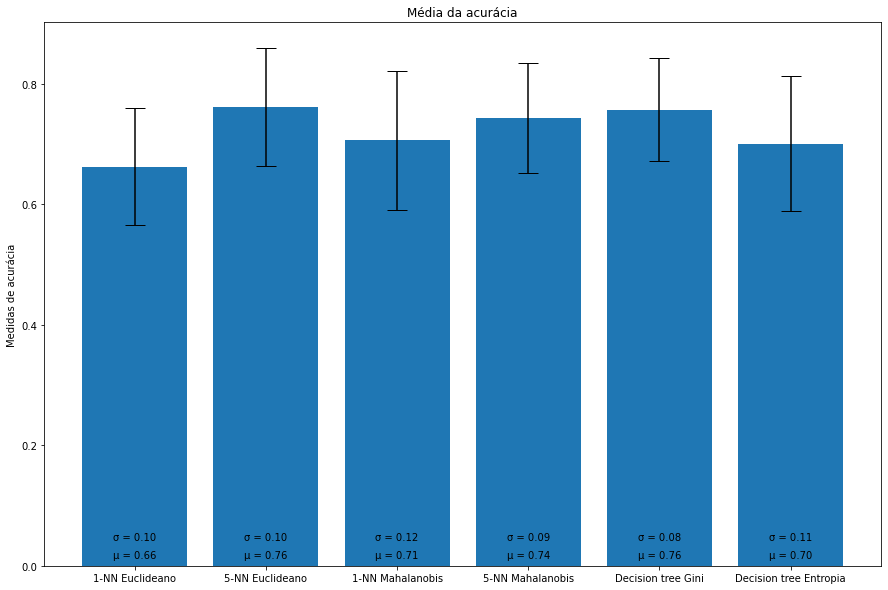

In [8]:
# Plota o gráfico da Acurácia
plt.figure(figsize=(15,10))

plt.title("Média da acurácia")

plt.ylabel("Medidas de acurácia")

bars = plt.bar(names, acuracia.mean(axis=1), yerr=np.std(acuracia, axis=1), capsize=10, align='center')

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2., 0.01, 'µ = {:.2f}'.format(acuracia.mean(axis=1)[i]), ha='center', va='bottom')
    plt.text(bar.get_x() + bar.get_width()/2., 0.04, 'σ = {:.2f}'.format(acuracia.std(axis=1)[i]), ha='center', va='bottom')
    
plt.show()

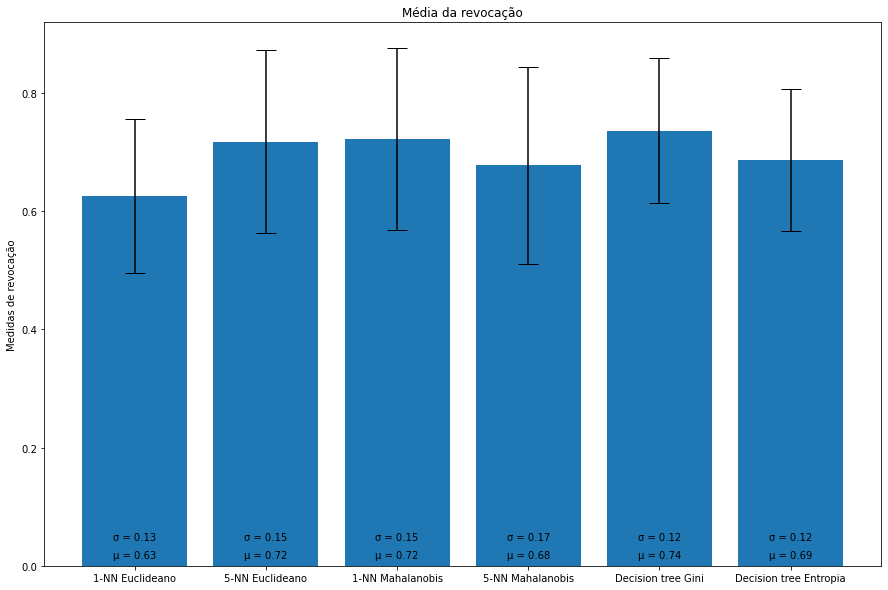

In [9]:
# Plota o gráfico da Revocação
plt.figure(figsize=(15,10))

plt.title("Média da revocação")

plt.ylabel("Medidas de revocação")

bars = plt.bar(names, revocacao.mean(axis=1), yerr=np.std(revocacao, axis=1), capsize=10, align='center')

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2., 0.01, 'µ = {:.2f}'.format(revocacao.mean(axis=1)[i]), ha='center', va='bottom')
    plt.text(bar.get_x() + bar.get_width()/2., 0.04, 'σ = {:.2f}'.format(revocacao.std(axis=1)[i]), ha='center', va='bottom')
    
plt.show()

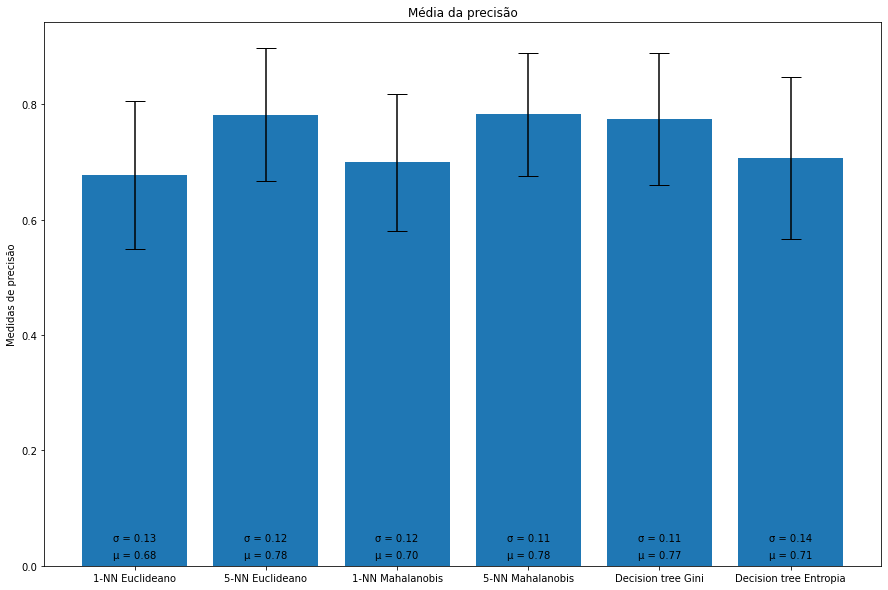

In [10]:
# Plota o gráfico da Precisão
plt.figure(figsize=(15,10))

plt.title("Média da precisão")

plt.ylabel("Medidas de precisão")

bars = plt.bar(names, precisao.mean(axis=1), yerr=np.std(precisao, axis=1), capsize=10, align='center')

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2., 0.01, 'µ = {:.2f}'.format(precisao.mean(axis=1)[i]), ha='center', va='bottom')
    plt.text(bar.get_x() + bar.get_width()/2., 0.04, 'σ = {:.2f}'.format(precisao.std(axis=1)[i]), ha='center', va='bottom')

plt.show()

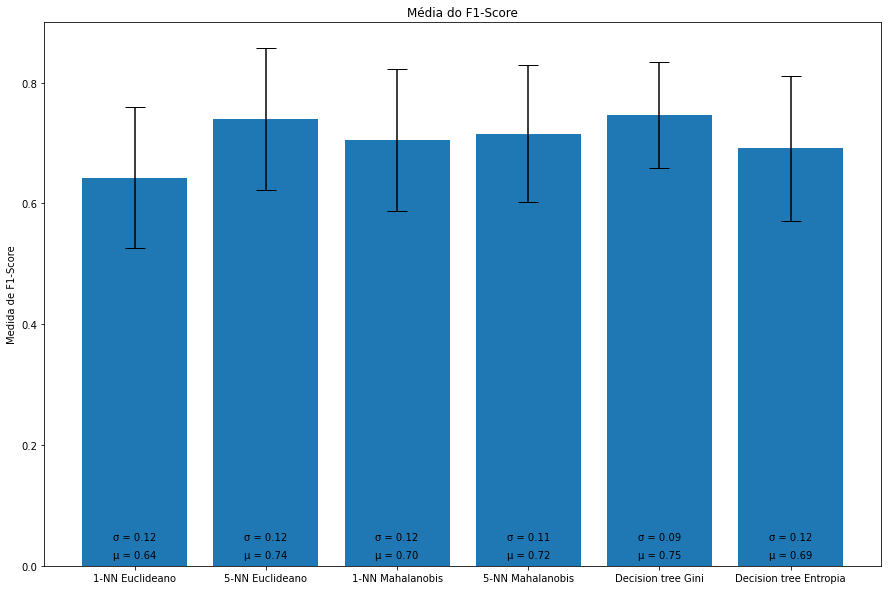

In [11]:
# Plota o gráfico do F1-Score
plt.figure(figsize=(15,10))

plt.title("Média do F1-Score")

plt.ylabel("Medida de F1-Score")

bars = plt.bar(names, f1_score.mean(axis=1), yerr=np.std(f1_score, axis=1), capsize=10, align='center')

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2., 0.01, 'µ = {:.2f}'.format(f1_score.mean(axis=1)[i]), ha='center', va='bottom')
    plt.text(bar.get_x() + bar.get_width()/2., 0.04, 'σ = {:.2f}'.format(f1_score.std(axis=1)[i]), ha='center', va='bottom')
    
    
plt.show()